<a href="https://colab.research.google.com/github/sanjaynagi/primerDesignAg/blob/main/Primer-Design-in-Anopheles-gambiae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First, install some packages we require
!pip install primer3-py malariagen_data scikit-allel

In [2]:
# Import libraries 
import pandas as pd 
import allel 
import malariagen_data
import numpy as np
import primer3
import seaborn as sns
import matplotlib.pyplot as plt

#**Primer design incorporating genetic variation in *Anopheles gambiae***
**Author**: Sanjay Curtis Nagi    
**Email**: sanjay.nagi@lstmed.ac.uk




Often, we would like to design primers for PCR applications, such as genotyping (PCR, TaqMan, LNA) or gene expression qPCR (SYBR, TaqMan, LNA). However, single nucleotide polymorphisms (SNPs) in primer binding sites can result in differences or failures in PCR amplification, referred to as null alleles. 

In general, mismatches caused by SNPs, are more of a problem as you move towards the 3' end. I recommend reading a really good article on this topic on the IDT website - [Consider SNPs when designing PCR and qPCR assays](https://eu.idtdna.com/pages/education/decoded/article/considering-snps-when-designing-pcr-and-qpcr-assays). In *An. gambiae s.l*, there is a [huge amount of genetic variation](https://genome.cshlp.org/content/30/10/1533.full); a SNP found approximately every 1.9 bases (!), which makes considering SNPs even more important when designing molecular assays. Thanks to primer3-py and the fantastic malariagen_data package, we can do all of this in the cloud, hosted by google!


###**Google Colab**

If you are unfamiliar with iPython notebooks and google colab, I encourage you to watch the following [introduction](https://www.youtube.com/watch?v=inN8seMm7UI). In general, the cells can be run by pressing the play button next to each cell, and should be run in order.

###**Future development**

Currently, the notebook supports only standard genomic DNA primers, however, we will add support for qPCR primers (which should span exon-exon junctions) and probe design. It will probably also be useful to have some form of batch primer design.

Any contributions or suggestions on how we can improve this notebook, are more than welcome. 

#### **Primer Design**
Set up our primer choices.

In [38]:
name = 'Example_primer'               # Name for primer set
contig = '2L'                         # Contig out of 2L, 2R, 3L, 3R and X 
target_snp = 28_545_000               # This should be the position in base pairs of where you want the primers to target. underscores mean nothing and are just helpful for reading large numbers. 
amplicon_size_range = [[125,225]]     # How large do we want the amplicon to be? here, e.g 125-225bp
n_primer_pairs = 20                   # How many primer pairs to request

Load sequence data for chromosomal arm of choice

In [39]:
# Connect to the malariagen_data ag3 API
ag3 = malariagen_data.Ag3() #pre=True

fasta = ag3.genome_sequence(region=contig)

# Set up range for the input sequence, we'll take the middle range of the amplicon size and add that either
# side of the target SNP
start = target_snp - np.mean(amplicon_size_range)
end = target_snp + np.mean(amplicon_size_range)

print(f"Our genome sequence for {contig} is {fasta.shape[0]} bp long")

Our genome sequence for 2L is 49364325 bp long


In [40]:
# join array into be one character string, and store the positions of these sequences for later
target_sequence = ''.join(fasta[start-1:end].compute().astype(str))
gdna_pos = np.arange(start, end).astype(int)
print(f"The target sequence is {len(target_sequence)} bases long")

The target sequence is 351 bases long


In [41]:
target_sequence

'CCCCGGTATCGACATTGGCCAGATTGAGGGTGCGTTTGTGATGGGCATTGGGCTGTACTTTACCGAGCAGCTCGTCTACAGCGGGGAGTCGGGCCAGCTGCTGACCAACCGCTCCTGGAACTACAAACCGCCTGGTGCGAAGGATATTCCGGTCGACTTTCGCGTCAAGTTTTTGCAGCGCACACACAACGAAAACTTTGTACTGCGGTCGAAAACGACCGGTGAGCCAGCGCTCAACATGACCGTGTCGTTGCTATTTGCTCTGCGCATGGCACTGAACTCGGCACGCAAGCAGGCCGGTCTGCCCGATGAGTGGTATCCGATCGGTGAGTAGTGTTTGGTTGGAGGTGT'

To tell primer3 where to target, we need to convert our genome wide positions to the positions in the target sequence

In [42]:
# We need the target snp indices within the region of interest
target_snp_primer3 = int(np.where(gdna_pos == target_snp)[0])
target_snp_primer3 = [target_snp_primer3, 10]
print(f"the target snp is {target_snp_primer3[0]} bp into our target sequence")

the target snp is 175 bp into our target sequence


Set up some dictionaries containing our sequence and primer parameters, this will be our input to primer3. 
 
Here, you can modify primer3 parameters, such as optimal TM, GC content etc etc. A full list of possible parameters and their functions can be found in the [primer3 manual](https://primer3.org/manual.html).

In [43]:
seq_parameters = {
        'SEQUENCE_ID': name,
        'SEQUENCE_TEMPLATE': target_sequence,
        'SEQUENCE_TARGET': target_snp_primer3
    }
    
primer_parameters  =  {
        'PRIMER_NUM_RETURN':n_primer_pairs,
        'PRIMER_OPT_SIZE': 20,
        'PRIMER_PICK_RIGHT_PRIMER':1,
        'PRIMER_PICK_INTERNAL_OLIGO': 0, 
        'PRIMER_PICK_LEFT_PRIMER':1,
        'PRIMER_TASK':'generic',
        'PRIMER_INTERNAL_MAX_SELF_END': 8,
        'PRIMER_MIN_SIZE': 17,
        'PRIMER_MAX_SIZE': 24,
        'PRIMER_OPT_TM': 60.0,
        'PRIMER_MIN_TM': 57.0,
        'PRIMER_MAX_TM': 63.0,
        'PRIMER_MIN_GC': 30.0,
        'PRIMER_MAX_GC': 75.0,
        'PRIMER_MAX_POLY_X': 100,
        'PRIMER_INTERNAL_MAX_POLY_X': 100,
        'PRIMER_SALT_MONOVALENT': 50.0,
        'PRIMER_DNA_CONC': 50.0,
        'PRIMER_MAX_NS_ACCEPTED': 0,
        'PRIMER_MAX_SELF_ANY': 12,
        'PRIMER_MAX_SELF_END': 8,
        'PRIMER_PAIR_MAX_COMPL_ANY': 12,
        'PRIMER_PAIR_MAX_COMPL_END': 8,
        'PRIMER_PRODUCT_SIZE_RANGE': amplicon_size_range,
        'PRIMER_EXPLAIN_FLAG':1,
        'PRIMER_MIN_THREE_PRIME_DISTANCE':3                           # This sets the minimum distance in bases, for pairs of primersa
    }

#### **Run the primer3 algorithm!**

In [56]:
primer_dict = primer3.designPrimers(seq_parameters, primer_parameters)

'primer_dict' is a python dictionary containing the full outputs from primer3. We will turn this into a pandas dataframe, containing just the necessary bits of information. First, lets print some general info from the primer3 run. The first 7 rows of the data frame are statistics from the run. 

In [86]:
primer_df = pd.DataFrame.from_dict(primer_dict.items())          # Convert the dict into a pandas dataframe
primer_df = primer_df.rename(columns={0:'parameter', 1:'value'}) # Rename the columns
explanations_df = primer_df.iloc[:7, :]                          # Take the first 7 rows which are general

for idx, row in explanations_df.iterrows():                      # Loop through each row and print information
    print(row['parameter'], " : ", row['value'], "\n")

PRIMER_LEFT_EXPLAIN  :  considered 1244, GC content failed 36, low tm 220, high tm 482, high hairpin stability 18, ok 488 

PRIMER_RIGHT_EXPLAIN  :  considered 1172, GC content failed 23, low tm 227, high tm 484, high hairpin stability 90, ok 348 

PRIMER_PAIR_EXPLAIN  :  considered 1532, unacceptable product size 1508, primer in pair overlaps a primer in a better pair 6693, ok 24 

PRIMER_LEFT_NUM_RETURNED  :  20 

PRIMER_RIGHT_NUM_RETURNED  :  20 

PRIMER_INTERNAL_NUM_RETURNED  :  0 

PRIMER_PAIR_NUM_RETURNED  :  20 



In [90]:
# Create a column which is primer pair #, and a column for primer parameter which does not contain primer pair #
primer_df = primer_df.iloc[7:, :].copy()
primer_df['primer_pair'] = primer_df['parameter'].str.extract("([0-9][0-9]|[0-9])")
primer_df['parameter'] = primer_df['parameter'].str.replace("(_[0-9][0-9]|_[0-9])", "", regex=True)


# Put the different primer pairs in different columns
primer_df = primer_df.pivot(index='parameter', columns='primer_pair', values='value')

# Get a list of the rows we need 
primer_span = ['PRIMER_LEFT', 'PRIMER_RIGHT']
required_info = ['SEQUENCE', 'TM', 'GC_PERCENT']
required_info = [p + "_" + y for y in required_info for p in primer_span] + primer_span + ['PRIMER_PAIR_PRODUCT_SIZE']

# Subset data frame
primer_df = primer_df.loc[required_info, np.arange(primer_df.shape[1]).astype(str)]
primer_df

primer_pair,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
parameter,,,,,,,,,,,,,,,,,,,,
PRIMER_LEFT_SEQUENCE,TGCGAAGGATATTCCGGTCG,TCCTGGAACTACAAACCGCC,TGGTGCGAAGGATATTCCGG,GTGCGTTTGTGATGGGCATT,TGGAACTACAAACCGCCTGG,CAACCGCTCCTGGAACTACA,TATTCCGGTCGACTTTCGCG,GATGGGCATTGGGCTGTACT,GTCGACTTTCGCGTCAAGTT,CGGTATCGACATTGGCCAGA,CGTTTGTGATGGGCATTGGG,GGGCTGTACTTTACCGAGCA,GCCTGGTGCGAAGGATATTC,ACCGCTCCTGGAACTACAAAC,CCAGATTGAGGGTGCGTTTG,CGAAGGATATTCCGGTCGACT,CGGTCGACTTTCGCGTCAA,GAGCAGCTCGTCTACAGCG,ATTGGCCAGATTGAGGGTGC,TCGACTTTCGCGTCAAGTTTTT
PRIMER_RIGHT_SEQUENCE,GGATACCACTCATCGGGCAG,TAGCAACGACACGGTCATGT,GCAAATAGCAACGACACGGT,ACGACACGGTCATGTTGAGC,CACCGATCGGATACCACTCA,CGATCGGATACCACTCATCGG,ACTCACCGATCGGATACCAC,CTGGCTCACCGGTCGTTTTC,TACCACTCATCGGGCAGACC,TCGACCGCAGTACAAAGTTT,ACCGCAGTACAAAGTTTTCGT,GTCATGTTGAGCGCTGGC,TGCCGAGTTCAGTGCCATG,CTTGCGTGCCGAGTTCAGT,GTTTTCGACCGCAGTACAAAG,AACACTACTCACCGATCGGA,CCAACCAAACACTACTCACCG,GAGTTCAGTGCCATGCGC,CTGGCTCACCGGTCGTT,ACACCTCCAACCAAACACTACT
PRIMER_LEFT_TM,59.968415,59.964261,59.894036,60.038343,60.250553,59.679626,60.523968,60.106519,59.149144,59.89588,60.108709,59.751711,58.769676,60.270678,59.476928,59.392372,61.012414,60.585002,60.685458,59.650725
PRIMER_RIGHT_TM,59.965941,59.684114,59.484436,60.944311,58.970319,60.13566,58.969543,61.566018,61.32769,57.771862,58.717593,59.517626,60.67203,60.95617,58.100023,58.169721,59.128961,59.517626,59.271021,59.4917
PRIMER_LEFT_GC_PERCENT,55.0,55.0,55.0,50.0,55.0,55.0,55.0,55.0,50.0,55.0,55.0,55.0,55.0,52.380952,55.0,52.380952,57.894737,63.157895,55.0,40.909091
PRIMER_RIGHT_GC_PERCENT,60.0,50.0,50.0,55.0,55.0,57.142857,55.0,60.0,60.0,45.0,42.857143,61.111111,57.894737,57.894737,47.619048,50.0,52.380952,61.111111,64.705882,45.454545
PRIMER_LEFT,"(135, 20)","(112, 20)","(132, 20)","(29, 20)","(115, 20)","(105, 20)","(144, 20)","(39, 20)","(151, 20)","(3, 20)","(32, 20)","(49, 20)","(129, 20)","(107, 21)","(18, 20)","(137, 21)","(149, 19)","(64, 19)","(13, 20)","(152, 22)"
PRIMER_RIGHT,"(320, 20)","(255, 20)","(260, 20)","(250, 20)","(328, 20)","(325, 21)","(331, 20)","(229, 20)","(317, 20)","(211, 20)","(208, 21)","(242, 18)","(285, 19)","(291, 19)","(215, 21)","(337, 20)","(344, 21)","(281, 18)","(229, 17)","(350, 22)"
PRIMER_PAIR_PRODUCT_SIZE,186,144,129,222,214,221,188,191,167,209,177,194,157,185,198,201,196,218,217,199



Lets write this to a .tsv file, which can be stored and explored in other editors if necessary. To download a file from colab to your local computer, click the folder panel on the left-hand sidebar, the three dots next your primers.tsv file, and download.

In [91]:
primer_df.to_csv(f"{name}.primers.tsv", sep="\t")

##**Looking for variation using the ag1000g resource and malariagen API**

We can load any sample set from the Ag3 resource. Lets look at what each sample set contains...

In [92]:
metadata = ag3.sample_metadata()

Load sample metadata:   0%|          | 0/28 [00:00<?, ?it/s]

In [93]:
pivot_country_year_taxon = (
    metadata
    .pivot_table(
        index=["sample_set", "year", "country"], 
        columns=["taxon"], 
        values="sample_id",
        aggfunc="count",
        fill_value=0
    )
)
pivot_country_year_taxon

taxon                                               arabiensis  coluzzii  \
sample_set   year country                                                  
AG1000G-AO   2009 Angola                                     0        81   
AG1000G-BF-A 2012 Burkina Faso                               0        82   
AG1000G-BF-B 2014 Burkina Faso                               3        53   
AG1000G-BF-C 2004 Burkina Faso                               0         0   
AG1000G-CD   2015 Democratic Republic of the Congo           0         0   
AG1000G-CF   1993 Central African Republic                   0         5   
             1994 Central African Republic                   0        13   
AG1000G-CI   2012 Cote d'Ivoire                              0        80   
AG1000G-CM-A 2009 Cameroon                                   0         0   
AG1000G-CM-B 2005 Cameroon                                   0         7   
AG1000G-CM-C 2013 Cameroon                                   2        19   
AG1000G-FR   2011 Mayotte                                    0         0   
AG1000G-GA-A 2000 Gabon                                      0         0   
AG1000G-GH   2012 Ghana                                      0        64   
AG1000G-GM-A 2011 Gambia, The                                0         0   
AG1000G-GM-B 2012 Gambia, The                                0         2   
AG1000G-GM-C 2012 Gambia, The                                0         0   
AG1000G-GN-A 2012 Guinea                                     0         3   
AG1000G-GN-B 2012 Guinea                                     0         7   
                  Mali                                       0        28   
AG1000G-GQ   2002 Equatorial Guinea                          0         0   
AG1000G-GW   2010 Guinea-Bissau                              0         0   
AG1000G-KE   2012 Kenya                                     10         0   
             2000 Kenya                                      0         0   
             2007 Kenya                                      3         0   
AG1000G-ML-A 2014 Mali                                       0        27   
AG1000G-ML-B 2004 Mali                                       2        36   
AG1000G-MW   2015 Malawi                                    41         0   
AG1000G-MZ   2004 Mozambique                                 0         0   
             2003 Mozambique                                 0         0   
AG1000G-TZ   2012 Tanzania                                  87         0   
             2015 Tanzania                                 137         0   
             2013 Tanzania                                   1         0   
AG1000G-UG   2012 Uganda                                    82         0   

taxon                                               gambiae  gcx1  gcx2  gcx3  \
sample_set   year country                                                       
AG1000G-AO   2009 Angola                                  0     0     0     0   
AG1000G-BF-A 2012 Burkina Faso                           98     0     0     0   
AG1000G-BF-B 2014 Burkina Faso                           46     0     0     0   
AG1000G-BF-C 2004 Burkina Faso                           13     0     0     0   
AG1000G-CD   2015 Democratic Republic of the Congo       76     0     0     0   
AG1000G-CF   1993 Central African Republic                2     0     0     0   
             1994 Central African Republic               53     0     0     0   
AG1000G-CI   2012 Cote d'Ivoire                           0     0     0     0   
AG1000G-CM-A 2009 Cameroon                              303     0     0     0   
AG1000G-CM-B 2005 Cameroon                               90     0     0     0   
AG1000G-CM-C 2013 Cameroon                               23     0     0     0   
AG1000G-FR   2011 Mayotte                                23     0     0     0   
AG1000G-GA-A 2000 Gabon                                  69     0     0     0   
AG1000G-GH   2012 Ghana                         

For the purposes of this notebook, I'm going to use the Ghana sample set. If we wanted to use all sample sets, we could supply '3.0' instead of a sample_set, which will use all samples from the ag3.0 release.

In [94]:
sample_set = ['AG1000G-GH']               # sample_set = '3.0'

Next, I will define some functions for pl

In [99]:
def span_to_freq(primer_range, sample_set):

  """
  This function takes the primer genomic range, and calculates allele frequencies at those sites, 
  from the ag3 sample set of your choice.
  """
  span=f'{contig}:{primer_range[0]}-{primer_range[1]}'                        
  primer_ref_seq = ag3.genome_sequence(region=span).compute()         # get dna sequence for span
  geno = ag3.snp_genotypes(region=span, sample_sets=sample_set).compute() # get genotypes
  ac = allel.GenotypeArray(geno).count_alleles()                      
  freqs = ac.to_frequencies()
  alt_freqs = freqs[:, 1:].sum(axis=1)                                # Get summed frequency of alts (?)

  df = pd.DataFrame({'position':np.arange(primer_range[0], primer_range[1]+1), 'base':primer_ref_seq.astype(str), 'alt_frequency':alt_freqs}) # Make dataframe for plotting
  df['base_pos'] = df['base'] + "_" + df['position'].astype(str) 
  return(df)

def get_primer_alt_frequencies(pair, sample_set):
  """
  Find the genomic locations of pairs of primers, and runs span_to_freq
  to get allele frequencies at those locations
  """
  primer_loc_fwd = primer_df.loc['PRIMER_LEFT', f'{pair}'][0]
  primer_size_fwd = primer_df.loc['PRIMER_LEFT', f'{pair}'][1]
  primer_loc_rev = primer_df.loc['PRIMER_RIGHT', f'{pair}'][0]
  primer_size_rev = primer_df.loc['PRIMER_RIGHT', f'{pair}'][1]
  
  primer_range_fwd = [gdna_pos[primer_loc_fwd], gdna_pos[primer_loc_fwd]+primer_size_fwd]
  primer_range_rev = [gdna_pos[primer_loc_rev-1]-(primer_size_rev), gdna_pos[primer_loc_rev-1]]

  fwd_df = span_to_freq(primer_range_fwd, sample_set)
  rev_df = span_to_freq(primer_range_rev, sample_set)

  return(fwd_df, rev_df)

def plot_pair_text(pair, ax, side, dict_dfs):
  """
  Plot text relating to primer characteristics (Tm etc)
  """
  tm = np.round(primer_df.loc[f'PRIMER_{side}_TM', f'{pair}'], 2)
  gc = primer_df.loc[f'PRIMER_{side}_GC_PERCENT', f'{pair}']
  span = f"{dict_dfs[i]['position'].min()}-{dict_dfs[i]['position'].max()}"

  ax.text(x=2, y=0.5, s=f"TM={tm}", bbox=dict(facecolor='white', edgecolor='black', alpha=0.2, boxstyle='round', pad=0.5))
  ax.text(x=2, y=0.7, s=f"GC={gc}", bbox=dict(facecolor='white', edgecolor='black', alpha=0.2, boxstyle='round', pad=0.5))
  ax.text(x=2, y=0.9, s=span, bbox=dict(facecolor='white', edgecolor='black', alpha=0.2, boxstyle='round', pad=0.5))
  ax.text(x=0.5, y=0.9, s="5'")
  ax.text(x=18, y=0.9, s="3'")

def plot_primers(ax, i, dict_dfs, side='LEFT'):
  """
  Plot primer allele frequencies and text
  """
  sns.scatterplot(ax=ax, x=dict_dfs[i]['base_pos'], y=dict_dfs[i]['alt_frequency'], s=200)  # hue=di_f[i]['base']
  ax.set_xticklabels(dict_dfs[i]['base'])
  ax.set_ylim(0,1)
  ax.set_xlabel("")
  ax.set_ylabel("Alternate allele frequency")
  if side == 'RIGHT': 
    ax.set_ylabel("")
    ax.set_yticklabels("")
  ax.set_title(f"FWD primer {i}") if side == 'LEFT' else  ax.set_title(f"REV primer {i}") 
  plot_pair_text(i, ax, side, dict_dfs)


### **Plot allele frequencies in primers locations**

Now we can plot the primers and the frequency of any alternate alleles. We will also plot the primer Tm, GC and genomic spans. Using these plots, we can identify primers which may be suitable, particularly trying to avoid SNPs in the 3' end. 

IndexError: ignored

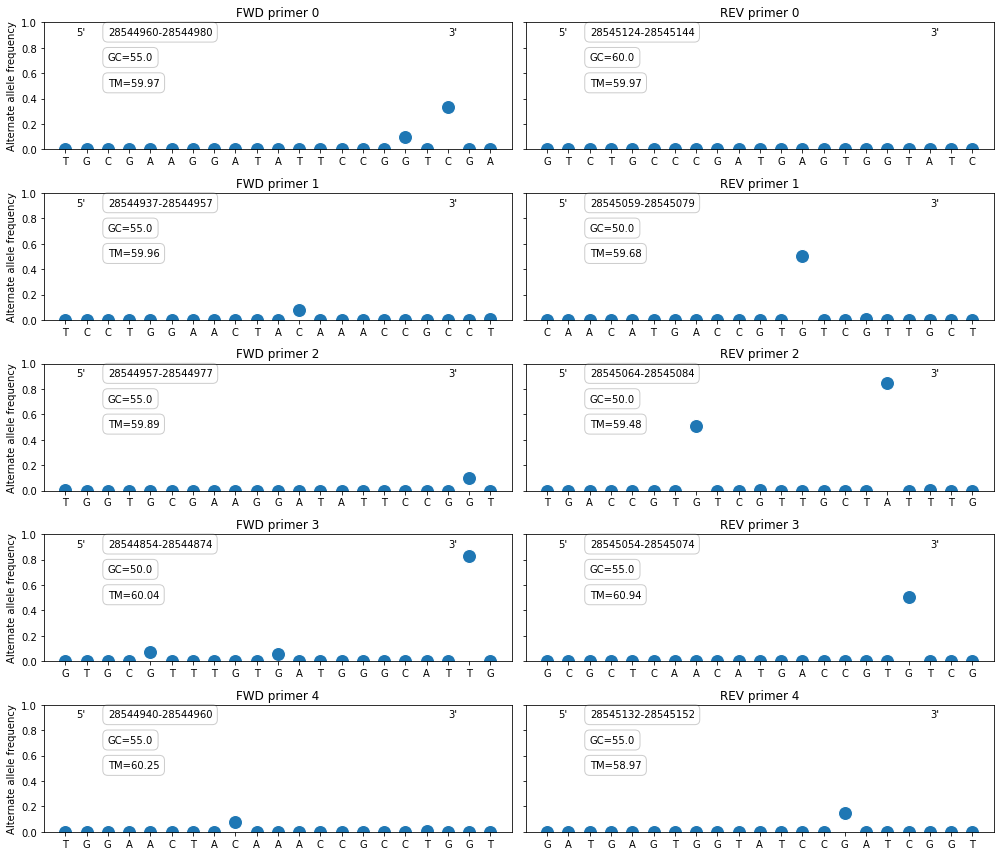

In [100]:
di_f = {}
di_r = {}
# Loop through each primer pair and get the frequencies of alternate alleles, storing in dict
for i in range(n_primer_pairs):
  di_f[i], di_r[i] = get_primer_alt_frequencies(i, sample_set)

# Plot data
fig, ax = plt.subplots(5,2, figsize=[14,12])    
for i in range(n_primer_pairs):
  plot_primers(ax[i,0], i, di_f, side='LEFT')
  plot_primers(ax[i,1], i, di_r, side='RIGHT')
  plt.tight_layout()

In [ ]:
primer_df

We may now have designed suitable primers. However, there are some further considerations...


- Primers must be run in NCBI Blast, to ensure specificity against the host organism, and specificity for the genomic location of interest.

- If in multiplexed use with other primers or probes, primers must not interact with each other. This can be investigated using the IDT tool [oligoanalyzer](https://eu.idtdna.com/calc/analyzer).

- many more considerations.... (TODO)